In [1]:
import plot
import utils
from vaccine_allocation_model.State import State
from vaccine_allocation_model.MDP import MarkovDecisionProcess
from vaccine_allocation_model.GA import SimpleGeneticAlgorithm
from vaccine_allocation_model.Policy import Policy
from vaccine_allocation_model.SEAIR import SEAIR
import numpy as np
from pandas import Timedelta
from tqdm import tqdm
from functools import partial
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

# Set initial parameters
runs = 15
decision_period = 28
start_day, start_month, start_year = 24, 2, 2020
start_date = utils.get_date(f"{start_year}{start_month:02}{start_day:02}")
end_day, end_month, end_year = 31, 7, 2021  # 1,1,2021
end_date = utils.get_date(f"{end_year}{end_month:02}{end_day:02}")
horizon = int(Timedelta(end_date-start_date).days // (decision_period/4))
initial_infected = 10
policies = ['random', 'no_vaccines', 'susceptible_based', 
        'infection_based', 'oldest_first', 'contact_based', 
        'weighted', 'fhi_policy']
policy_number = 2
weights = np.array([0, 0, 0, 1, 0])

# Read data and generate parameters
paths = utils.create_named_tuple('paths', 'filepaths.txt')
config = utils.create_named_tuple('config', paths.config)
age_labels = utils.generate_labels_from_bins(config.age_bins)
population = utils.generate_custom_population(config.age_bins, age_labels)
contact_matrices = utils.generate_contact_matrices(config.age_bins, age_labels, population)
age_group_flow_scaling = utils.get_age_group_flow_scaling(config.age_bins, age_labels, population)
death_rates = utils.get_age_group_fatality_prob(config.age_bins, age_labels)
expected_years_remaining = utils.get_expected_yll(config.age_bins, age_labels)
commuters = utils.generate_commuter_matrix(age_group_flow_scaling)
response_measure_model = utils.load_response_measure_models()
historic_data = utils.get_historic_data()

# Run settings
run_GA = False
include_flow = True
stochastic = True
use_wave_factor = True
use_response_measures = True
verbose = False
plot_results = False
plot_geo = False
write_simulations_to_file = False

vaccine_policy = Policy(
                config=config,
                policy='weighted' if run_GA else policies[policy_number],
                population=population[population.columns[2:-1]].values,
                contact_matrices=contact_matrices,
                age_flow_scaling=age_group_flow_scaling,
                GA=run_GA)

epidemic_function = SEAIR(
                commuters=commuters,
                contact_matrices=contact_matrices,
                population=population,
                age_group_flow_scaling=age_group_flow_scaling,
                death_rates=death_rates,
                config=config,
                include_flow=include_flow,
                stochastic=stochastic,
                use_wave_factor=use_wave_factor)

initial_state = State.generate_initial_state(
                num_initial_infected=initial_infected,
                contact_weights=config.initial_contact_weights,
                flow_scale=config.initial_flow_scale,
                population=population,
                start_date=start_date)

mdp = MarkovDecisionProcess(
                config=config,
                decision_period=decision_period,
                population=population, 
                epidemic_function=epidemic_function,
                initial_state=initial_state,
                response_measure_model=response_measure_model, 
                use_response_measures=use_response_measures,
                use_wave_factor=use_wave_factor,
                horizon=horizon,
                end_date=end_date,
                policy=vaccine_policy,
                historic_data=historic_data,
                verbose=verbose)


def get_objective(objective):
        return {"deaths": lambda state: np.sum(state.D),
                "infected": lambda state: np.sum(state.total_infected),
                "weighted": lambda state: np.sum(state.total_infected)*0.01 + np.sum(state.D),
                "yll": lambda state: utils.calculate_yll(expected_years_remaining, state.D.sum(axis=0))
                }[objective]

In [2]:
dir_path = "results/GA_2021_05_30_21_22_52/best_individuals/"
individuals = os.listdir(dir_path)
best_individuals = []
for ind in sorted(individuals, key=lambda x: int(x.split("_")[2][:-4])):
    best_individuals.append(utils.read_pickle(dir_path+ind))

In [4]:
best_individuals

[gen_0_029,
 gen_0_029,
 gen_0_023,
 gen_0_029,
 gen_0_029,
 gen_0_029,
 gen_6_007,
 gen_6_007,
 gen_8_012,
 gen_8_012,
 gen_8_012,
 gen_8_012,
 gen_8_012,
 gen_11_001,
 gen_11_001,
 gen_13_009,
 gen_16_012,
 gen_16_012,
 gen_16_012,
 gen_16_012,
 gen_16_012]

In [6]:
runs=20
individual_results = defaultdict(partial(defaultdict, int))
for i in tqdm(range(runs)):
    np.random.seed(i)
    mdp.init()
    generation_results = []
    for gen, individual in enumerate(best_individuals):
        mdp.reset()
        mdp.run(individual.genes)
        generation_results.append(mdp.state)
    for gen, state in enumerate(generation_results):
        for obj in ["deaths", "infected", "weighted", "yll"]:
            individual_results[gen][obj] = get_objective(obj)(state)

 10%|█         | 2/20 [01:07<10:01, 33.44s/it]Total infected for start state < 40 000 (35957.65611747831).
Total infected for start state < 40 000 (23312.418720457834).
 75%|███████▌  | 15/20 [08:21<02:51, 34.23s/it]Total infected for start state < 40 000 (23694.53179794561).
Total infected for start state < 40 000 (3460.2539330561362).
100%|██████████| 20/20 [11:10<00:00, 33.50s/it]


In [7]:
deaths = [individual_results[k]["deaths"] for k in individual_results.keys()]
infected = [individual_results[k]["infected"] for k in individual_results.keys()]
weighted = [individual_results[k]["weighted"] for k in individual_results.keys()]
yll = [individual_results[k]["yll"] for k in individual_results.keys()]

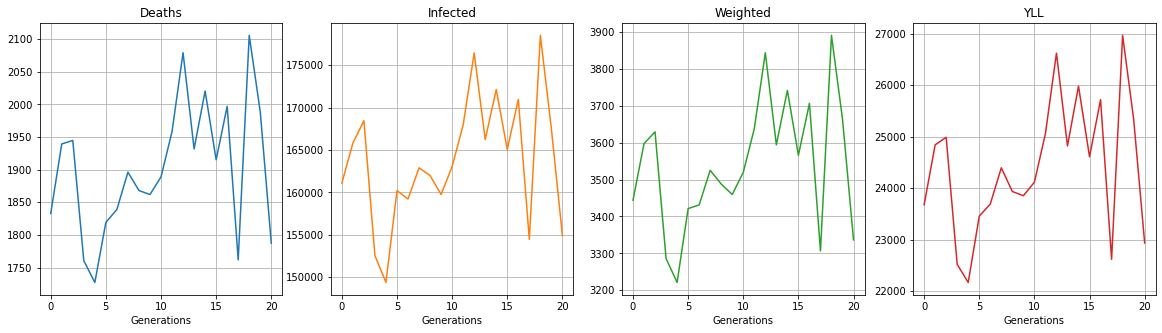

In [8]:
x=np.arange(len(deaths))
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
sns.lineplot(x=x, y=deaths, ax=axs[0], color="C0")
sns.lineplot(x=x, y=infected, ax=axs[1], color="C1")
sns.lineplot(x=x, y=weighted, ax=axs[2], color="C2")
sns.lineplot(x=x, y=yll, ax=axs[3], color="C3")
axs[0].set_title("Deaths")
axs[1].set_title("Infected")
axs[2].set_title("Weighted")
axs[3].set_title("YLL")
for ax in axs:
    ax.grid()
    ax.set_xlabel("Generations")
plt.show()